In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# Define a custom dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST training set
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the MNIST test set
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Epoch 1/10, Training Loss: 0.2911, Training Accuracy: 91.69%
Testing Loss: 0.1205, Testing Accuracy: 96.31%
Epoch 2/10, Training Loss: 0.1009, Training Accuracy: 97.03%
Testing Loss: 0.0840, Testing Accuracy: 97.33%
Epoch 3/10, Training Loss: 0.0711, Training Accuracy: 97.86%
Testing Loss: 0.0690, Testing Accuracy: 97.82%
Epoch 4/10, Training Loss: 0.0574, Training Accuracy: 98.20%
Testing Loss: 0.0542, Testing Accuracy: 98.35%
Epoch 5/10, Training Loss: 0.0464, Training Accuracy: 98.58%
Testing Loss: 0.0545, Testing Accuracy: 98.23%
Epoch 6/10, Training Loss: 0.0381, Training Accuracy: 98.82%
Testing Loss: 0.0603, Testing Accuracy: 98.21%
Epoch 7/10, Training Loss: 0.0321, Training Accuracy: 98.92%
Testing Loss: 0.0581, Testing Accuracy: 98.08%
Epoch 8/10, Training Loss: 0.0273, Training Accuracy: 99.10%
Testing Loss: 0.0520, Testing Accuracy: 98.37%
Epoch 9/10, Training Loss: 0.0232, Training Accuracy: 99.24%
Testing Loss: 0.0534, Testing Accuracy: 98.43%
Epoch 10/10, Training Loss: 

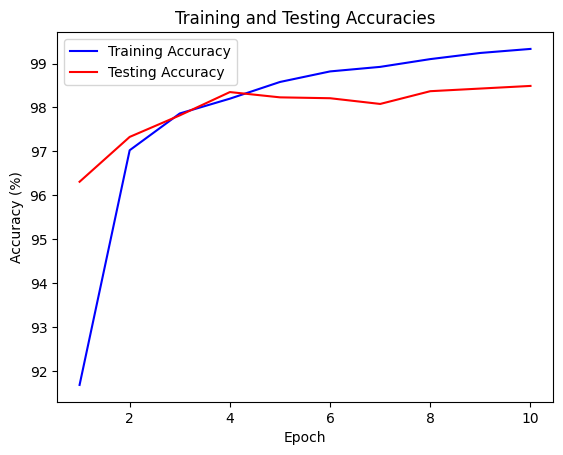

Final Training Accuracy: 99.33%
Final Testing Accuracy: 98.49%
Trained model saved


In [7]:
# Initialize the model & define hyperparameters
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 30
num_epochs = 10

train_accuracies = []
test_accuracies = []
writer = SummaryWriter()

for epoch in range(num_epochs):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # Training Loop
    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_accuracy = 100.0 * train_correct / train_total

    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    # Write training metrics to Tensorboard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    # Testing loop
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_loss += loss.item() * images.size(0)

    test_loss /= len(test_dataset)
    test_accuracy = 100.0 * test_correct / test_total

    test_accuracies.append(test_accuracy)
    print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.2f}%')

    # Write testing metrics to Tensorboard
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)

    # Select a few images from the test dataset
    sample_images, _ = next(iter(test_loader))
    # Write the images to Tensorboard
    writer.add_images('Images', sample_images, global_step=epoch)

# Close the SummaryWriter
writer.close()

# Plot the training and testing accuracies over epochs
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Print overall training and testing accuracies
print(f'Final Training Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Final Testing Accuracy: {test_accuracies[-1]:.2f}%')

# Save the trained model
torch.save(model.state_dict(), os.path.join("models", "MNIST.pth"))
print("Trained model saved")

In [8]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 36872), started 0:39:33 ago. (Use '!kill 36872' to kill it.)

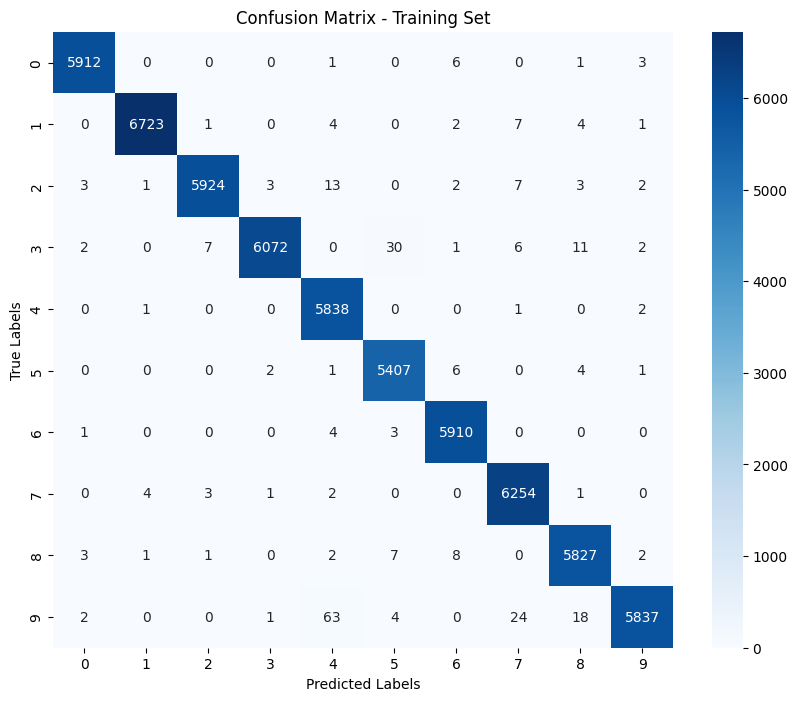

In [6]:
# Generate the confusion matrix for the training set
train_predictions = []
train_true_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_true_labels.extend(labels.tolist())

train_cm = confusion_matrix(train_true_labels, train_predictions)

class_names = [str(i) for i in range(10)]
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Input tensor shape: torch.Size([1, 28, 28])
Predicted MNIST label: 2


C:\Users\siddh\AppData\Local\Temp\ipykernel_6980\2665167798.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preprocessed_image_tensor = torch.tensor(preprocessed_image, dtype=torch.float32)


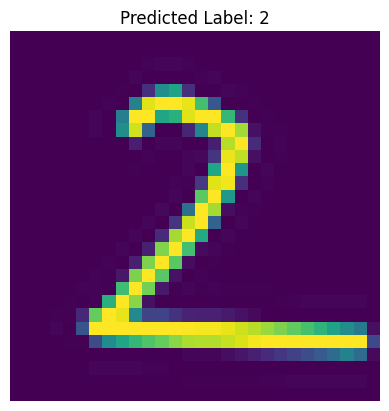

SystemExit: 0

c:\Users\siddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
# DRAWING APP FOR MNIST
import sys
import numpy as np
import torch
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QVBoxLayout, QPushButton
from PyQt5.QtGui import QPainter, QPen, QImage, QColor
from PyQt5.QtCore import Qt, QPoint
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def classify_mnist_image(image):
    model = NeuralNetwork()
    model.load_state_dict(torch.load(os.path.join("models", "MNIST.pth")))
    
    image_with_batch = image.unsqueeze(0)
    with torch.no_grad():
        output = model(image_with_batch)
        _, predicted_label = torch.max(output, 1)
        predicted_label = predicted_label.item()
    return predicted_label

class DrawingCanvas(QWidget):
    def __init__(self):
        super().__init__()
        self.image = QImage(500, 500, QImage.Format_RGB32)
        self.image.fill(Qt.white)
        self.last_point = QPoint()

    def paintEvent(self, event):
        painter = QPainter(self)
        painter.drawImage(self.rect(), self.image, self.rect())

    def mousePressEvent(self, event):
        if event.button() == Qt.LeftButton:
            self.last_point = event.pos()

    def mouseMoveEvent(self, event):
        if event.buttons() & Qt.LeftButton:
            painter = QPainter(self.image)
            painter.setPen(QPen(Qt.black, 35, Qt.SolidLine, Qt.RoundCap, Qt.RoundJoin))
            painter.drawLine(self.last_point, event.pos())
            self.last_point = event.pos()
            
            # Draw a light black trail over the cursor
            for i in range(5):
                alpha = 100 - i  # Decrease opacity for each line
                painter.setPen(QPen(QColor(0, 0, 0, alpha), 60, Qt.SolidLine, Qt.RoundCap, Qt.RoundJoin))
                painter.drawLine(self.last_point + QPoint(i, i), event.pos() + QPoint(i, i))
                painter.drawLine(self.last_point - QPoint(i, i), event.pos() - QPoint(i, i))

            self.update()

    def clear_canvas(self):
        self.image.fill(Qt.white)
        self.update()

    def classify_canvas(self):
        preprocessed_image = self.preprocess_image()
        preprocessed_image_tensor = torch.tensor(preprocessed_image, dtype=torch.float32)
        print("Input tensor shape:", preprocessed_image_tensor.shape)
        
        predicted_label = classify_mnist_image(preprocessed_image_tensor)
        print(f"Predicted MNIST label: {predicted_label}")
        self.plot_image(preprocessed_image[0], predicted_label)



    def preprocess_image(self):
        # Convert QImage to PIL Image
        pil_image = Image.fromqimage(self.image)

        # Convert the image to grayscale (L mode)
        pil_image = pil_image.convert("L")
        pil_image = ImageOps.invert(pil_image)
        
        # Resize to 28x28 pixels (MNIST image size)
        pil_image = pil_image.resize((28, 28), Image.LANCZOS)  # Use LANCZOS for resampling

        # Convert PIL Image to numpy array
        image_array = np.array(pil_image)

        # Normalize pixel values to [0, 1]
        image_array = image_array / 255.0

        # Add a batch dimension to the image
        image_tensor = torch.tensor(image_array, dtype=torch.float32)
        image_tensor = image_tensor.unsqueeze(0)

        # Return the preprocessed image as a tensor
        return image_tensor


    def plot_image(self, image_array, label):
        # Reshape the image_array from (1, 28, 28) to (28, 28)
        image_array = image_array.reshape(28, 28)
        plt.imshow(image_array)
        plt.title(f"Predicted Label: {label}")
        plt.axis('off')
        plt.show()


class DrawingApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.initUI()

    def initUI(self):
        self.canvas = DrawingCanvas()

        self.clear_button = QPushButton('Clear Canvas', self)
        self.clear_button.clicked.connect(self.canvas.clear_canvas)

        self.classify_button = QPushButton('Classify', self)
        self.classify_button.clicked.connect(self.canvas.classify_canvas)

        layout = QVBoxLayout()
        layout.addWidget(self.canvas)
        layout.addWidget(self.clear_button)
        layout.addWidget(self.classify_button)

        container = QWidget()
        container.setLayout(layout)
        self.setCentralWidget(container)

        self.setGeometry(100, 100, 500, 600)
        self.setWindowTitle('MNIST Drawing App')


app = QApplication(sys.argv)
window = DrawingApp()
window.show()
sys.exit(app.exec_())


In [26]:
# DEPLOYMENT - must be done on a SageMaker notebook instance
import tarfile
import sagemaker
import boto3
from sagemaker.pytorch import PyTorchModel

model_file_path = os.path.join("models", "MNIST.pth")
archive_path = 'MNIST.tar.gz'

# Create a tar.gz archive
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(model_file_path, arcname='MNIST.pth')

print('tar.gz archive created successfully.')

# Upload the model tar.gz archive to S3
s3_bucket = 'sid-MNIST-bucket'
s3_model_key = 'MNIST.tar.gz'
s3_model_path = f's3://{s3_bucket}/{s3_model_key}'

s3_client = boto3.client('s3')
s3_client.upload_file(archive_path, s3_bucket, s3_model_key)

# Create an endpoint using SageMaker Python SDK
role = sagemaker.get_execution_role()
sess = sagemaker.Session()

# Create a PyTorchModel
pytorch_model = PyTorchModel(model_data=s3_model_path,
                             role=role,
                             entry_point = "inference.py",
                             framework_version='1.8.1',
                             py_version='py3',
                             sagemaker_session=sess)

# Deploy the model to an endpoint
endpoint_name = 'MNIST-endpoint-sid'
predictor = pytorch_model.deploy(endpoint_name=endpoint_name,
                                 initial_instance_count=1,
                                 instance_type='ml.m5.large')

# Wait for the deployment to complete
sess.wait_for_endpoint(endpoint_name)

tar.gz archive created successfully.
------------------------------------!


In [4]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define a custom dataset for the generated images
class GeneratedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Transform for the generated images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the model
model = NeuralNetwork()
model.load_state_dict(torch.load(os.path.join("models", "MNIST.pth")))
model.eval()

# Load the generated images dataset
generated_images_dataset = GeneratedImageDataset(root_dir="generated_images", transform=transform)
generated_images_loader = DataLoader(generated_images_dataset, batch_size=1, shuffle=False)

# Testing loop for generated images
predicted_labels = []
with torch.no_grad():
    for i, image in enumerate(generated_images_loader, 1):
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_labels.append(predicted.item())
        print(f"Generated Image {i}: Predicted Label - {predicted.item()}")

print("Inference on generated images completed.")

Generated Image 1: Predicted Label - 9
Generated Image 2: Predicted Label - 0
Generated Image 3: Predicted Label - 1
Generated Image 4: Predicted Label - 1
Generated Image 5: Predicted Label - 0
Generated Image 6: Predicted Label - 7
Generated Image 7: Predicted Label - 9
Generated Image 8: Predicted Label - 3
Generated Image 9: Predicted Label - 9
Generated Image 10: Predicted Label - 1
Generated Image 11: Predicted Label - 3
Generated Image 12: Predicted Label - 1
Generated Image 13: Predicted Label - 3
Generated Image 14: Predicted Label - 4
Generated Image 15: Predicted Label - 7
Generated Image 16: Predicted Label - 5
Generated Image 17: Predicted Label - 1
Generated Image 18: Predicted Label - 4
Generated Image 19: Predicted Label - 5
Generated Image 20: Predicted Label - 7
Generated Image 21: Predicted Label - 9
Generated Image 22: Predicted Label - 4
Generated Image 23: Predicted Label - 7
Generated Image 24: Predicted Label - 5
Generated Image 25: Predicted Label - 5
Generated